## Read data and create Dataframe

In [2]:
import os
import pandas as pd
import numpy as np

GROUP = "AM"

INPUT_PATH = "../../Downloads/Audio"

# Get csv data
csv_files = [ file for file in os.listdir(INPUT_PATH) if ".csv" in file and file != "AM_who_is_talking.csv" ]

# Get audio files
audio_files = [ file for file in os.listdir(INPUT_PATH) if ((".wav" in file) & (file not in csv_files)) ]

print(csv_files)

['AM_conf_trim.wav.csv', 'AM_pid1_trim.wav.csv', 'AM_pid3_trim.wav.csv', 'AM_pid2_trim.wav.csv']


In [3]:
# Loudness of each mic

df = pd.DataFrame()

for i, file in enumerate(csv_files):
    
    if "_conf" in file:
        ext = "conf"
    else:
        ext = "pid" + file[file.find("pid") + 3]
        
    temp_df = pd.read_csv(os.path.join(INPUT_PATH, file))
    
    # start and end time stamps -- files are synced
    if i == 0:
        df['start'] = temp_df['start']
        df['end'] = temp_df['end']
    
    df[f"Loudness_{ext}"] = temp_df['Loudness_sma3']

df.head()

,start,end,Loudness_conf,Loudness_pid1,Loudness_pid3,Loudness_pid2
0,0 days 00:00:00,0 days 00:00:00.020000,0.129840,0.026259,0.025662,0.094732
1,0 days 00:00:00.010000,0 days 00:00:00.030000,0.127732,0.025168,0.024983,0.102169
2,0 days 00:00:00.020000,0 days 00:00:00.040000,0.138426,0.024509,0.024033,0.112490
3,0 days 00:00:00.030000,0 days 00:00:00.050000,0.162534,0.023480,0.022020,0.110796
4,0 days 00:00:00.040000,0 days 00:00:00.060000,0.216453,0.022911,0.022171,0.097784


## Correlation between mic loudness

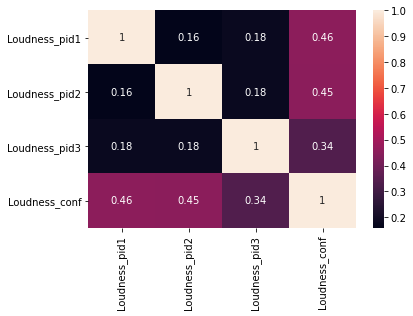

In [4]:
import seaborn as sn
import matplotlib.pyplot as plt

ordered_df = df[['Loudness_pid1', 'Loudness_pid2', 'Loudness_pid3', 'Loudness_conf']]

corrMatrix = ordered_df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

The correlation matrix shows, as expected, that **participant mics are well insulated while the conference mic is not.**

## Normalization
Creation of `_norm` columns. Columns with the loudness columns normalized to a 0-10 range.

In [5]:
range = 10

for col in ["Loudness_pid1", "Loudness_pid2", "Loudness_pid3", "Loudness_conf"]:
    df[col + "_norm"] = df[col] * range / max(1, np.abs(df[col].max()))

## Thresholding
Adding the absolute threshold values from the previous github repo.

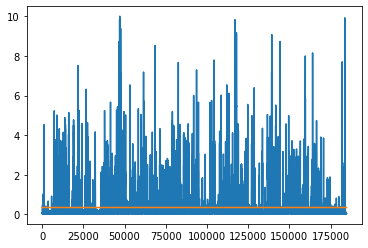

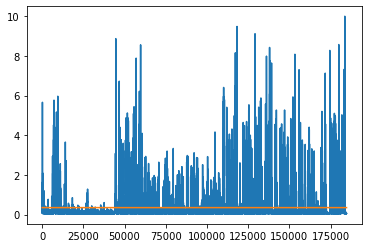

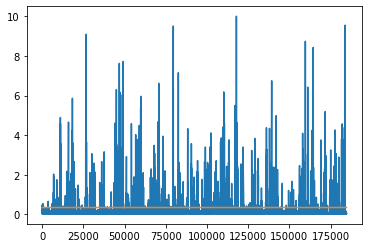

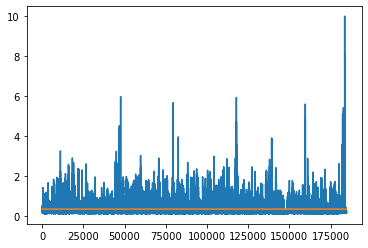

In [6]:
# Plots the normalized data and its distribution relative to the chosen absolute thresold

thresh = 0.35 # approximate of 575/16384 found in github repo

for id in ["pid1", "pid2", "pid3", "conf"]:
    col = "Loudness_%s_norm" % (id)

    plt.figure()
    plt.plot(df[col])
    plt.plot(np.ones(len(df)) * thresh)

In [7]:
for id in ["pid1", "pid2", "pid3", "conf"]:
    norm = "Loudness_%s_norm" % (id)
    df[id + "_speaking"] = df[norm] > thresh

## `jibo_speaking` 
Since the `conf` mic is susceptible to loudness in other mics, we say jibo is speaking if the conference mic's loudness is greater than `thresh` *AND* all other mics are below the loudness `thresh` 

In [8]:
df["jibo_speaking"] = df.apply(lambda x: x["conf_speaking"] and not (x["pid1_speaking"] or x["pid2_speaking"] or x["pid3_speaking"]) , axis=1)

In [9]:
df.head()

,start,end,Loudness_conf,Loudness_pid1,Loudness_pid3,Loudness_pid2,Loudness_pid1_norm,Loudness_pid2_norm,Loudness_pid3_norm,Loudness_conf_norm,pid1_speaking,pid2_speaking,pid3_speaking,conf_speaking,jibo_speaking
0,0 days 00:00:00,0 days 00:00:00.020000,0.129840,0.026259,0.025662,0.094732,0.045466,0.231781,0.045116,0.172129,False,False,False,False,False
1,0 days 00:00:00.010000,0 days 00:00:00.030000,0.127732,0.025168,0.024983,0.102169,0.043577,0.249977,0.043922,0.169335,False,False,False,False,False
2,0 days 00:00:00.020000,0 days 00:00:00.040000,0.138426,0.024509,0.024033,0.112490,0.042436,0.275229,0.042253,0.183513,False,False,False,False,False
3,0 days 00:00:00.030000,0 days 00:00:00.050000,0.162534,0.023480,0.022020,0.110796,0.040653,0.271085,0.038714,0.215472,False,False,False,False,False
4,0 days 00:00:00.040000,0 days 00:00:00.060000,0.216453,0.022911,0.022171,0.097784,0.039669,0.239249,0.038980,0.286954,False,False,False,False,False


# Output

| Participant | Column        |
|-------------|---------------|
| 1           | pid1_speaking |
| 2           | pid2_speaking |
| 3           | pid3_speaking |
| jibo        | jibo_speaking |

In [11]:
for id in ["pid1", "pid2", "pid3", "jibo"]:
    
    results = []
    count = 0
    speaking = False
    THRESHOLD = 10
    
    for entry in df[id + "_speaking"]:
        if count >= THRESHOLD:
            speaking = not speaking
            count = 0
        elif speaking != entry:
            count += 1
        else:
            count = 0
        results.append(speaking)
    
    df[id + "_speaking_2"] = results

In [12]:
df.head()

,start,end,Loudness_conf,Loudness_pid1,Loudness_pid3,Loudness_pid2,Loudness_pid1_norm,Loudness_pid2_norm,Loudness_pid3_norm,Loudness_conf_norm,pid1_speaking,pid2_speaking,pid3_speaking,conf_speaking,jibo_speaking,pid1_speaking_2,pid2_speaking_2,pid3_speaking_2,jibo_speaking_2
0,0 days 00:00:00,0 days 00:00:00.020000,0.129840,0.026259,0.025662,0.094732,0.045466,0.231781,0.045116,0.172129,False,False,False,False,False,False,False,False,False
1,0 days 00:00:00.010000,0 days 00:00:00.030000,0.127732,0.025168,0.024983,0.102169,0.043577,0.249977,0.043922,0.169335,False,False,False,False,False,False,False,False,False
2,0 days 00:00:00.020000,0 days 00:00:00.040000,0.138426,0.024509,0.024033,0.112490,0.042436,0.275229,0.042253,0.183513,False,False,False,False,False,False,False,False,False
3,0 days 00:00:00.030000,0 days 00:00:00.050000,0.162534,0.023480,0.022020,0.110796,0.040653,0.271085,0.038714,0.215472,False,False,False,False,False,False,False,False,False
4,0 days 00:00:00.040000,0 days 00:00:00.060000,0.216453,0.022911,0.022171,0.097784,0.039669,0.239249,0.038980,0.286954,False,False,False,False,False,False,False,False,False


In [13]:
df.to_csv("../../Downloads/Audio/" + GROUP + "_who_is_talking.csv")